In [48]:
import numpy as np
import matplotlib.pyplot as plt
import csaps
from csaps import CubicSmoothingSpline as ss
from astropy.stats import sigma_clip
import warnings
from scipy.optimize import minimize_scalar
import os
from os.path import join as opj
from lib_lc_norm_v4 import *

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [49]:
%matplotlib notebook

#%matplotlib inline

In [50]:
# target_name = '11904151'
target_name = '6276477'

# interest_idx = 0
# all_t0_bkjd = [131.574858, 138.678725]
# all_period_day = [0.837491225, 45.29422297]
# all_duration_day = np.array([1.796, 6.83])*1.5/24

interest_idx = -69
all_t0_bkjd = [2455003.937]
all_period_day = [10.35533116]
all_duration_day = np.array([3.4276])*1.5/24

In [51]:
for i in range(len(all_t0_bkjd)):
    
    t0i = all_t0_bkjd[i]
    
    if t0i < 1e4:
        
        all_t0_bkjd[i] = bkjd2bjd(t0i)

In [52]:
# lc = get_lightcurves(kid=target_name, quarters=range(18), quality_bitmask='hard', return_file_dirs=False)


from lightkurve.lightcurve import LightCurve
from astropy.io import fits
from lightkurve.search import search_lightcurvefile

# lc_file = fits.open('/media/rd1/hwei/downloaded_kepids/' +'KIC'+ str(target_name) + '.fits')

res = search_lightcurvefile(target_name, radius=None, 
                            cadence='long', #
                            #cadence='short', 
                            mission=('Kepler'),#, 'K2', 'TESS'), 
                            quarter=None, month=None, 
                            campaign=None, 
                            #campaign=16, 
                            sector=None, 
                            limit=None,
                            #limit=10,
                           )

lc = res.download_all(quality_bitmask='hard')

try:
    lc = lc.PDCSAP_FLUX.stitch()
except:
    pass

# print("ORIGINAL KEPID: " + str(target_name))
# lc_file.info() # there should be just two entires, 0 and 1, but check to be sure theres not a third one (2)
# print(len(lc_file[1].data.TIME))

# lc = LightCurve(lc_file[1].data.TIME, lc_file[1].data.FLUX, lc_file[1].data.FLUX_ERR, time_format = 'bkjd')
# lc

lc = lc.remove_nans()

In [53]:
time, flux, flux_err = lc.time, lc.flux, lc.flux_err

if 1:
    time = np.array(lc.astropy_time.value)# - 2400000.5

<IPython.core.display.Javascript object>


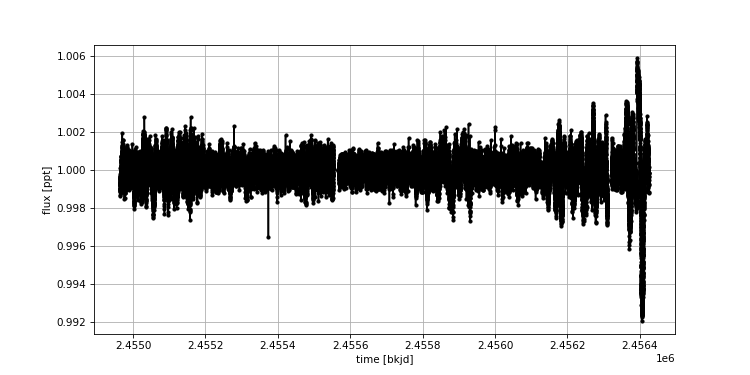

In [54]:
plt.figure(figsize=(10, 5))
plt.plot(time, flux, '.-k')
plt.grid(1)
plt.xlabel('time [bkjd]')
plt.ylabel('flux [ppt]');
plt.show(block=0)

<IPython.core.display.Javascript object>


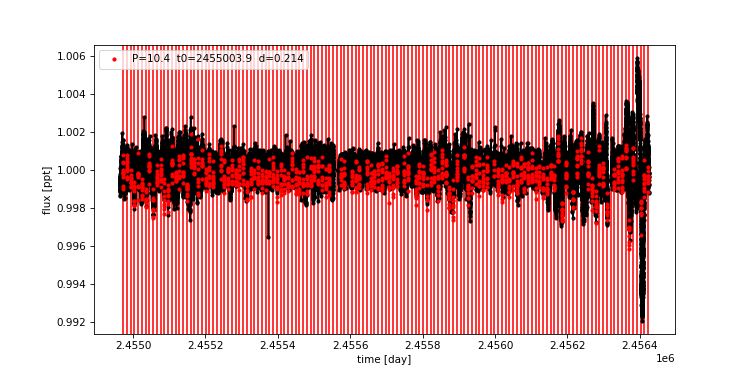

In [55]:
plot_mp_transits_v0(np.array(all_t0_bkjd), all_period_day, all_duration_day, time, flux, interest_idx)

In [57]:
# Determine time gap threshold

print('Time Stats:\nMin = ' + str(np.nanmin(np.diff(time))) +
      '\nMax = ' + str(np.nanmax(np.diff(time))) +
      '\nMedian = ' + str(np.nanmedian(np.diff(time))) +
      '\nSD = ' + str(np.nanstd(np.diff(time))))

#time_gap_thresh = np.nanstd(np.diff(time)) * 10
time_gap_thresh = np.nanmedian(np.diff(time)) * 3


print(time_gap_thresh)

Time Stats:
Min = 0.0204284037463367
Max = 15.835588049143553
Median = 0.020433685276657343
SD = 0.10302781748472384
0.06130105582997203


Data broken into 64 sections


<IPython.core.display.Javascript object>


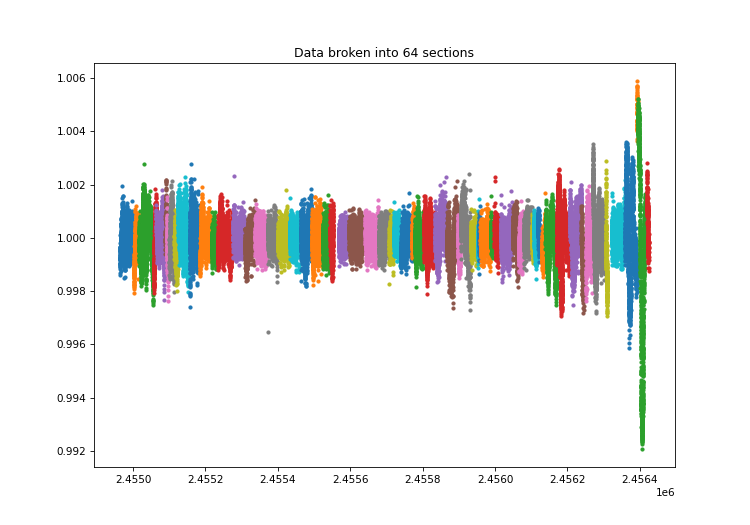

In [58]:
time_gap_thresh = 3 / 24

all_time, all_flux, all_flux_err = [],[],[]

split_idx = split(time, flux,  
                  gap_width=time_gap_thresh, 
                  dft=np.std(lc.flux) * 5.0, 
                  index_only=True)

for idx in split_idx:
    
    all_time.append(time[idx])
    all_flux.append(flux[idx])
    all_flux_err.append(flux_err[idx])
       
plot_q = 1
print('Data broken into ' + str(len(all_time)) + ' sections')

if plot_q:

    plt.figure(figsize=(10, 7))
    plt.title('Data broken into ' + str(len(all_time)) + ' sections')

    for ci in np.arange(len(all_flux)):

        plt.plot(all_time[ci], all_flux[ci], '.')

    plt.show()
    plt.pause(1.0)
    
all_time0, all_flux0, all_flux_err0 = np.copy(all_time), np.copy(all_flux), np.copy(all_flux_err)

In [59]:
# Cut sections that are lest than 50 points long

all_time, all_flux, all_flux_err = [], [], []
for i in np.arange(len(all_time0)):
    
    transit_idx = mask_mulit_transits(all_t0_bkjd, all_period_day, duration_day=all_duration_day, 
                                      time_bkjd=all_time0[i], 
                                      flux=all_flux0[i], 
                                      lc=None, 
                                      return_index=True)
    
    gi = len(all_time0[i][~transit_idx]) > 30

    if gi:
        all_time.append(all_time0[i])
        all_flux.append(all_flux0[i])
        all_flux_err.append(all_flux_err0[i])
        
    else:
        print('Filtered section', i)

# Determine fit smoothing required

In [60]:
# smoothing_strength_type = 'low'
smoothing_strength_type = 'med'
# smoothing_strength_type = 'high'
# smoothing_strength_type = 'IDK'
# smoothing_strength_type = 'custom'


if smoothing_strength_type == 'low':
    
    smooth_bnds = [0.998, 1.0]
    
elif smoothing_strength_type == 'med':
    
    smooth_bnds = [0.45, 0.55]
    
elif smoothing_strength_type == 'high':
    
    smooth_bnds = [0.0, 0.1]
    
elif smoothing_strength_type == 'IDK':

    smooth_bnds = [0.0, 1.0]
    
elif smoothing_strength_type == 'custom':

    smooth_bnds = [0.0, 1.0]
    
    
print('smooth_bnds', smooth_bnds)


warnings.filterwarnings("ignore", category=UserWarning)

cn = 0

vs = 1

smooth_bnds = [smooth_bnds[0] * vs, smooth_bnds[1] * vs]

mask_transit_q = 1

fit_sds = [7, 5, 3, 2.5]

# Mask the transit
if mask_transit_q:

    transit_idx = mask_mulit_transits(all_t0_bkjd, 
                                      all_period_day, 
                                      duration_day=all_duration_day, 
                                      time_bkjd=all_time[cn], 
                                      flux=all_flux[cn], 
                                      lc=None, 
                                      return_index=True)

else:

    transit_idx = np.zeros(len(all_time[cn]), dtype=bool)

weights = np.float64(~transit_idx)

weights[weights==0.0] = 1e-5

#sigma = meas_sig(all_time[cn], all_flux[cn], weights, plot_q=1)

sigma = rms(np.diff(all_flux[cn][~transit_idx]))


mdt = np.median(np.abs(np.diff(all_time[cn])))

if (len(all_time[cn]) > 500):# & (all_time[cn][-1] - all_time[cn][0] < 1.5):

    dt = mdt * 100

elif len(all_time[cn]) < 50:
    
    dt = mdt * 10

elif all_time[cn][-1] - all_time[cn][0] < 1.5:

    dt = (all_time[cn][-1] - all_time[cn][0]) / 4
    
elif all_time[cn][-1] - all_time[cn][0] < 5:
    
    #dt = np.median(np.abs(np.diff(all_time[cn]))) * 10.1
    dt = (all_time[cn][-1] - all_time[cn][0]) / 4
    #dt = all_time[cn][-1] - all_time[cn][0]
else:
    dt = 1
    #dt = mdt * 30
    
dt = 5

bins = np.arange(all_time[cn][0], all_time[cn][-1] + 1, dt)

t_bins = np.digitize(all_time[cn], bins) - 1


res = minimize_scalar(min_smo, 
                      bounds=tuple(smooth_bnds), 
                      method='bounded', 
                      #method='golden', 
                      args=(all_time[cn], 
                          all_flux[cn], 
                          weights, 
                          transit_idx, 
                          fit_sds, 
                          sigma, vs, t_bins))


res.x = res.x / vs

print(res)

bsmo = res.x

# for smo in np.linspace(1e-5, 1-1e-5, 10):
    
#     min_smo(smo * vs, all_time[cn], 
#           all_flux[cn], 
#           weights, 
#           transit_idx, 
#           fit_sds, 
#           sigma, vs, t_bins)


# plt.figure(figsize=(8, 5))
# plt.plot(smo_h, lsq_h, '.-k')
# plt.plot(smo_h, c1_h, '.-r')
# plt.plot(smo_h, c2_h, '.-g')


# Make the final fit using the solved smoothing param
cont_fit_tmp, outliers_tmp = iter_filt_ssfit(all_time[cn], 
                                             all_flux[cn], weights, 
                                             ~transit_idx, 
                                             bsmo, sds=fit_sds, 
                                             return_filt_index=1, 
                                             plot_q=1)




smooth_bnds [0.45, 0.55]


ImportError: cannot import name 'UnivariateCubicSmoothingSpline' from 'csaps' (/opt/anaconda3/bin/csaps/__init__.py)

In [ ]:
def calc_lc_cont(all_time, all_flux, all_flux_err, smooth_bnds, all_t0_bkjd, all_period_day, all_duration_day, fit_sds=[7, 5, 3], mask_transit_q=True, force_smo_const=None):
    
    #mask_transit_q = True

    #fit_sds = [7, 5, 3] # Fitting iterative SD filter multiplers

    solver_var_scaler = 1 # Dont touch. Does nothing, b.

    smooth_bnds = [smooth_bnds[0] * solver_var_scaler, smooth_bnds[1] * solver_var_scaler]

    ####################################################################################
    # Fit each section
    
    cont_fit, time_norm, flux_norm, flux_err_norm, outliers = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])

    cont_fit_list, flux_norm_list, flux_err_norm_list, outliers_list = [], [], [], []

    sigs, ssmos = [], []

    for cn in range(len(all_time)):
        
        print(cn + 1, 'of', len(all_time))

        # Mask the transit
        if mask_transit_q:

            transit_idx = mask_mulit_transits(all_t0_bkjd, all_period_day, 
                                              duration_day=all_duration_day, 
                                              time_bkjd=all_time[cn], 
                                              flux=all_flux[cn], 
                                              lc=None, 
                                              return_index=True)

        else:

            transit_idx = np.zeros(len(all_time[cn]), dtype=bool)

        weights = np.float64(~transit_idx)

        weights[weights==0.0] = 1e-5

        sigma = rms(np.diff(all_flux[cn][~transit_idx]))

        mdt = np.median(np.abs(np.diff(all_time[cn])))

        dt = 5

        bins = np.arange(all_time[cn][0], all_time[cn][-1] + 1, dt)

        t_bins = np.digitize(all_time[cn], bins) - 1

        sigs.append(sigma)


        if force_smo_const != None:
            
            bsmo = force_smo_const
            
            
        else:
        
            res = minimize_scalar(min_smo, 
                                  bounds=tuple(smooth_bnds), 
                                  method='bounded', 
                                  args=(all_time[cn], 
                                        all_flux[cn], 
                                        weights, 
                                        transit_idx, 
                                        fit_sds, 
                                        sigma, 
                                        solver_var_scaler, 
                                        t_bins))


            bsmo = res.x / solver_var_scaler

        ssmos.append(bsmo)


        # Make the final fit using the solved smoothing param
        cont_fit_tmp, outliers_tmp = iter_filt_ssfit(all_time[cn], 
                                                     all_flux[cn], 
                                                     weights, 
                                                     ~transit_idx, 
                                                     bsmo, 
                                                     sds=fit_sds, 
                                                     return_filt_index=1, 
                                                     plot_q=0)

        flux_norm_tmp = all_flux[cn] / cont_fit_tmp

        flux_err_norm_tmp = all_flux_err[cn] / cont_fit_tmp


        cont_fit_list.append(cont_fit_tmp)

        flux_norm_list.append(flux_norm_tmp)

        flux_err_norm_list.append(flux_err_norm_tmp)

        outliers_list.append(outliers_tmp)
        

    sigs = np.array(sigs)
    ssmos = np.array(ssmos)

    print('Done')
    
    return cont_fit_list, flux_norm_list, flux_err_norm_list, outliers_list, sigs, ssmos

In [ ]:
cont_fit_list, flux_norm_list, flux_err_norm_list, outliers_list, sigs, ssmos = calc_lc_cont(all_time, all_flux, all_flux_err, 
                                                                                             smooth_bnds, 
                                                                                             all_t0_bkjd, all_period_day, all_duration_day, 
                                                                                             fit_sds=[7, 5, 3], 
                                                                                             mask_transit_q=True,
                                                                                             force_smo_const=0.45)

In [ ]:
end_clip = 30

cont_fit, time_norm, flux_norm, flux_err_norm, outliers = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])

for cn in range(len(all_time)):
    
    time_norm = np.concatenate((time_norm, all_time[cn][end_clip:-end_clip]))

    cont_fit = np.concatenate((cont_fit, cont_fit_list[cn][end_clip:-end_clip]))

    flux_norm = np.concatenate((flux_norm, flux_norm_list[cn][end_clip:-end_clip]))

    flux_err_norm = np.concatenate((flux_err_norm, flux_err_norm_list[cn][end_clip:-end_clip]))

    outliers = np.concatenate((outliers, outliers_list[cn][end_clip:-end_clip]))

In [ ]:
if plot_q:
        
    # Mask the transit
    if mask_transit_q:
        
        transit_idx = mask_mulit_transits(all_t0_bkjd, all_period_day, 
                                          duration_day=all_duration_day, 
                                          time_bkjd=time_norm, 
                                          flux=flux_norm, 
                                          lc=None, return_index=True)
        
    else:

        transit_idx = np.zeros(len(all_time[cn]), dtype=bool)

    plt.figure(figsize=(10, 7))

    #plt.plot(time_norm, flux_norm, '.k')
    plt.plot(time_norm, flux_norm, '.k')

    if mask_transit_q:
        plt.plot(time_norm[transit_idx], 
                 flux_norm[transit_idx], '.', 
                 c=[0,1,0,0.8], 
                 label='Transit (Area Masked During Fit)')

    plt.grid(1)
    plt.show()

In [ ]:
len(time), len(np.unique(time)), len(time_norm),len(flux_norm),len(flux_err_norm)

In [ ]:
outliers = np.int8(outliers)

_, gi, _ = np.intersect1d(time, time_norm, return_indices=1)

gi = np.sort(gi)

plt.figure(figsize=(10, 5))

for cn in range(len(all_time)):
    
    t = all_time[cn][end_clip:-end_clip]
    f = all_flux[cn][end_clip:-end_clip]
    c = cont_fit_list[cn][end_clip:-end_clip]
    
    plt.plot(t, f, '.', t, c, '-')
    plt.text(np.mean(t), 1, str(cn) + ' | ' + str(ssmos[cn]), fontsize=10)

In [ ]:
outliers = np.int8(outliers)

_, gi, _ = np.intersect1d(time, time_norm, return_indices=1)

gi = np.sort(gi)

plt.figure(figsize=(10, 5))
plt.plot(time_norm, flux[gi], '.k')
plt.plot(time_norm, cont_fit, '-m')
plt.plot(time_norm[outliers], flux[outliers], '.r')

In [ ]:
# All data saved here

data_save_dir = opj('/media/rd1/kwillis/light_curve_routines/data/norm_lcs')
os.makedirs(data_save_dir, exist_ok=1)


np.savez(opj(data_save_dir, target_name + '_LC_data.npz'), 
         flux=lc.flux, 
         flux_err=lc.flux_err, 
         time=lc.time, 
         time_norm=time_norm, 
         flux_norm=flux_norm, 
         flux_err_norm=flux_err_norm, 
         kic=target_name, 
         t0_pri_day=all_t0_bkjd, 
         p_day=all_period_day, 
         d_day=all_duration_day, 
        )

In [ ]:
all_t0_bkjd

In [ ]:
all_period_day

In [ ]:
all_duration_day